In [1]:
%matplotlib widget
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import morph_geom_lib as mgl
import models.shallow_depth_morph_models as sdmodels
import schemes.avalanche_scheme 


from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')

%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['dark_background'])

# TVD-WENO Scheme

https://www.ams.org/journals/mcom/1998-67-221/S0025-5718-98-00913-2/S0025-5718-98-00913-2.pdf

The TVD second order Runge-Kutta method we consider is the one given in
[12]:
$$u^{(1)} = u^n + ∆tL(u^n)$$,
$$u^{n+1} = 0.5u^n + 0.5u^{(1)} + 1/2∆tL(u^{(1)})$$


Z: 87
0.01569138276553106


Text(0, 0.5, 'z (m)')

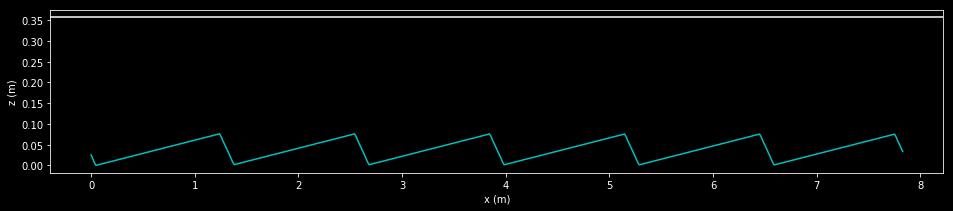

In [2]:
profile_folder = '/pymorph/notebooks/Paper_3/flume_profile_smoothed_v002.txt'
xc, z0 = mgl.readQueensFlume(profile_folder,1)

fig = plt.figure(figsize=(16, 3))
#plt.plot(xc,z0,'b')

dunes = 6

xsaw = np.linspace(0, 1,500)
simTime = 60*10 # Runtime in seconds
dt = 0.5 # Time step size (s)

zsaw = 0.076*(signal.sawtooth(2*dunes*np.pi * xsaw) + 1.)/2
xsaw = xsaw*xc.max()*dunes*0.5
#plt.plot(xsaw,zsaw)


dx = xsaw[1]-xsaw[0]
znew, iterations1 = schemes.avalanche_scheme.avalanche_model(dx,xsaw, zsaw, adjustment_angle=28.)
# Now flip it to run in reverse
zflip = np.flip(znew, axis=0)
zflip, iterations1 = schemes.avalanche_scheme.avalanche_model(dx,xsaw, zflip, adjustment_angle=28.)
znew = np.flip(zflip, axis=0)

znew = (znew - np.min(znew))/np.ptp(znew)
znew = znew*0.076

plt.plot(xsaw,znew,'-',color='c')
plt.axhline(0.357)
print(dx)
plt.xlabel('x (m)')
plt.ylabel('z (m)')

## Euler-WENO

 Starting simulation....
Number of time steps: 3.0 mins
Grid dx = 0.01569138276553106
Grid nx = 500
Initializing hydrodynamic model...
2019-05-14 20:42:58,374 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-14 20:43:17,853 INFO CLAW: Solution 1 computed for time t=300.000000
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Max qbedload = 6.685753100407271e-06
Avalanching!
2019-05-14 20:43:17,969 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-14 20:43:19,115 INFO CLAW: Solution 1 computed for time t=15.000000
Avalanching!
2019-05-14 20:43:19,178 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-14 20:43:20,322 INFO CLAW: Solution 1 computed for time t=15.000000
Avalanching!
2019-05-14 20:43:20,404 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-14 20:43:21,596 INFO CLAW: Solution 1 computed for time t=15.000000
Avalanching!
2019-05-14 20:43:21,694 INFO CLAW: Solution 0 computed for tim

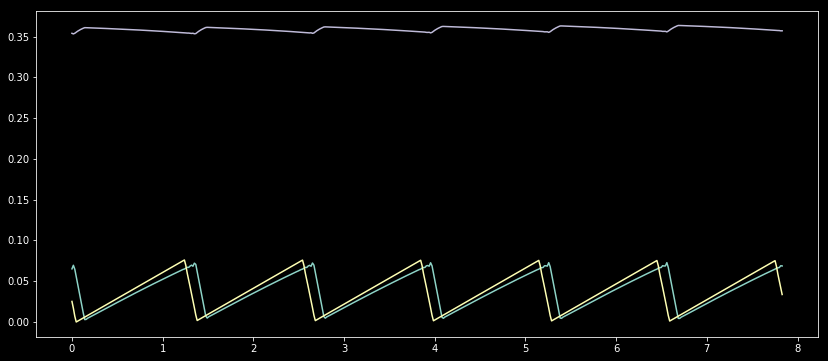

In [4]:
model = sdmodels.ShallowHydroMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = xsaw.copy()
zc = znew.copy()
x0 = xsaw.copy()
z0 = znew.copy()
nx = len(xc)

model.setup_domain(xc, zc, dx)

#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.247

model.flow_boundary_conditions(q32cm, sOut32)

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.

model.setup_hydro_model(mannings_n, bed_slope)


#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------

morph_model = sdmodels.EulerWenoModel()
# morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 15.*60       # Runtime in seconds
dt = 5                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*0.5


zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)

surf = zc + h

plt.plot(xc, surf)


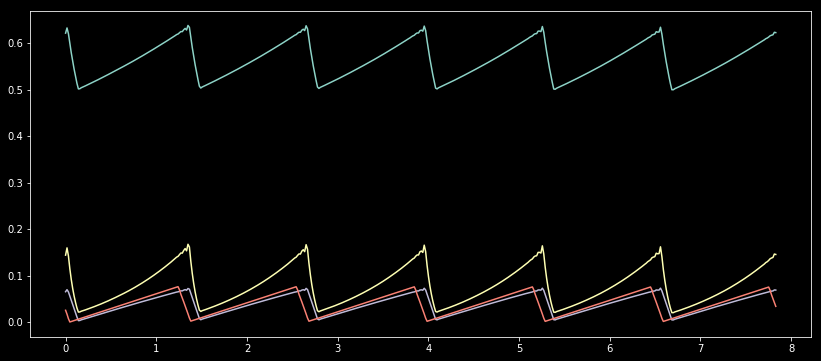

In [5]:
fig = plt.figure(figsize=(14, 6))
plt.plot(xc,u)
plt.plot(xc,qbedload*30000.)
plt.plot(xc,zc)
plt.plot(x0,z0)

In [6]:
model._wave_speed

{30: 1.3023847695390778,
 60: 1.3023847695390778,
 90: 0.01569138276553106,
 120: 0.01569138276553106,
 150: 0.01569138276553106,
 180: 0.01569138276553106,
 210: 0.03138276553106212,
 240: 0.03138276553106212,
 270: 0.03138276553106212,
 300: 0.03138276553106212,
 330: 0.04707414829659318,
 360: 0.04707414829659318,
 390: 0.01569138276553106,
 420: 0.01569138276553106,
 450: 0.01569138276553106,
 480: 0.01569138276553106,
 510: 0.03138276553106212,
 540: 0.03138276553106212,
 570: 0.03138276553106212,
 600: 0.03138276553106212,
 630: 0.04707414829659318,
 660: 0.04707414829659318,
 690: 0.04707414829659318,
 720: 0.04707414829659318,
 750: 0.06276553106212424,
 780: 0.01569138276553106,
 810: 0.06276553106212424,
 840: 0.06276553106212424,
 870: 0.03138276553106212}

## TVD-WENO

 Starting simulation....
Number of time steps: 3.0 mins
Grid dx = 0.01569138276553106
Grid nx = 500
Initializing hydrodynamic model...
2019-05-14 19:47:53,269 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-14 19:48:33,371 INFO CLAW: Solution 1 computed for time t=300.000000
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Max qbedload = 5.5854525956026904e-06
2019-05-14 19:48:33,428 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-14 19:48:33,915 INFO CLAW: Solution 1 computed for time t=10.000000
Avalanching!
2019-05-14 19:48:33,943 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-14 19:48:34,647 INFO CLAW: Solution 1 computed for time t=15.000000
2019-05-14 19:48:34,673 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-14 19:48:35,119 INFO CLAW: Solution 1 computed for time t=10.000000
Avalanching!
2019-05-14 19:48:35,149 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-14 1

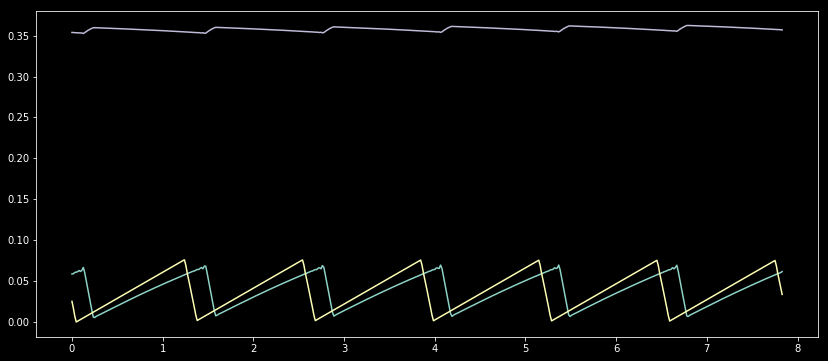

In [30]:
model.setup_hydro_model(Mannings, Slope)


#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------

morph_model = sdmodels.TVD2ndWenoModel()
# morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 15.*60       # Runtime in seconds
dt = 5                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*0.5


zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)

surf = zc + h

plt.plot(xc, surf)

In [34]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(z0, height=0.02)

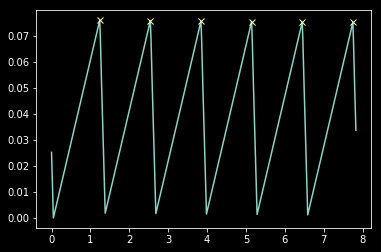

In [40]:
plt.plot(xc,z0)
plt.plot(xc[peaks], z0[peaks], "x")

In [46]:
peaks

array([ 79, 162, 245, 328, 411, 494])

for peak in peaks:
    print(peak)

In [48]:
model._peak1

array([ 79, 162, 245, 328, 411, 494])